# Root Cause Discovery + Lasso

Here for a known "root cause gene", lets run a Lasso regression to filter down the number of features, before running Root Cause Discovery algorithm

+ After processing, we obtained 2 datasets
    1. "Interventional data": there are 32 samples for which we have ground truth data. Each row is a gene and each column is a sample. 
    2. "observational data": these are a few hundred samples for which we did not do any intervention. Each row is a gene and each column is a sample.
+ The main idea is that an intervention supposedly caused a disturbance in gene expression, so we can compare the data of intervention to baseline (i.e. observational data), and try to which gene is most differentially expressed

In [1]:
# using Pkg
# Pkg.update("RootCauseDiscovery")

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using ProgressMeter
using LinearAlgebra
BLAS.set_num_threads(1)

using Plots
gr(fmt=:png)

# import RootCauseDiscovery.zscore
# import RootCauseDiscovery.compute_permutations
# import RootCauseDiscovery.root_cause_discovery
# import RootCauseDiscovery.find_largest
# import RootCauseDiscovery.find_second_largest

# using Statistics
# import StatsBase.cov2cor
# using GLMNet
# using CovarianceEstimation
# using LinearAlgebra
# using Plots
# gr(fmt=:png)
# include("/home/users/bbchu/RootCauseDiscovery/utilities.jl")

# helper function to submit 1 job to run 1 command
function submit(command::String, ncores::Int, total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        println(io, "# run code")
        println(io, "echo \"$command\"")
        println(io, "$command")
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

# helper function to submit 1 job to run multiple commands
function submit(commands::Vector{String}, ncores::Int, 
        total_mem::Number, joblog_dir::String; 
        jobname="submit", waitfor=Int[], verbose=true)
    mem = round(Int, total_mem / ncores) # memory per core
    filename = "$jobname.sh"
    open(filename, "w") do io
        println(io, "#!/bin/bash")
        println(io, "#")
        println(io, "#SBATCH --job-name=$jobname")
        println(io, "#")
        println(io, "#SBATCH --time=168:00:00")
        println(io, "#SBATCH --cpus-per-task=$ncores")
        println(io, "#SBATCH --mem-per-cpu=$(mem)G")
        println(io, "#SBATCH --partition=candes,zihuai")
        println(io, "#SBATCH --output=$(joinpath(joblog_dir, "slurm-%j.out"))")
        println(io, "")
        println(io, "#save job info on joblog:")
        println(io, "echo \"Job \$JOB_ID started on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID started on:   \" `date `")
        println(io, "")
        println(io, "# load the job environment:")
        println(io, "module load julia/1.10")
        println(io, "export JULIA_DEPOT_PATH=\"/home/groups/sabatti/.julia\"")
        println(io, "")
        for command in commands
            println(io, "echo \"$command\"")
            println(io, "$command")
        end
        println(io, "")
        println(io, "#echo job info on joblog:")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `hostname -s`")
        println(io, "echo \"Job \$JOB_ID ended on:   \" `date `")
        println(io, "#echo \" \"")
    end
    # submit job and capture job ID
    io = IOBuffer()
    if length(waitfor) != 0
        run(pipeline(`sbatch --dependency=afterok:$(join(waitfor, ':')) $filename`; stdout=io))
    else
        run(pipeline(`sbatch $filename`; stdout=io))
    end
    msg = String(take!(io))
    verbose && println(stdout, msg)
    jobid = parse(Int, strip(msg)[21:end])
    # clean up and return job ID
    close(io)
    rm(filename, force=true)
    return jobid
end

function make_plot(
        Z_score_rank::AbstractVector, 
        RCD_rank::AbstractVector, 
        patient_name::AbstractVector;
        plot1_ymax = 5500,
        plot2_ymin = -2500,
        plot2_ymax = 2500,
        title1 = "Root cause rank (Z-score vs Cholesky score)",
        title2 = "Original Z score rank - refined Z score rank"
    )
    # sort by diff in Z scores
    Z_score_diff = Z_score_rank - RCD_rank
    perm = sortperm(Z_score_diff)

    #
    # plot 1
    #
    plt1 = scatter(
        1:length(patient_name), 
        Z_score_rank[perm], 
        ylabel="rank", 
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        label = "Original z-score rank",
        title = title1,
        legend=:top,
        dpi=300,
        ylim=(0, plot1_ymax)
    )
    scatter!(plt1, 1:length(patient_name), RCD_rank[perm], label="Refined Z-score rank")

    #
    # plot 2
    #
    palettes = theme_palette(:auto)
    my_colors = []
    for i in eachindex(Z_score_diff)
        if isinf(Z_score_diff[i])
            push!(my_colors, :black)
            Z_score_diff[i] = plot2_ymin
        elseif Z_score_diff[i] > 0
            push!(my_colors, palettes[1])
        elseif Z_score_diff[i] == 0
            push!(my_colors, palettes[3])
        else
            push!(my_colors, palettes[2])
        end
    end

    # make plot
    plt2 = scatter(
        1:length(patient_name_success), 
        Z_score_diff[perm],
        title=title2, 
        ylabel="Rank difference",
        xticks=(1:length(patient_name), patient_name[perm]),
        xrotation = 50,
        ylim=(plot2_ymin, plot2_ymax),
        label = nothing,
        legend=:outerbottom,
        color=my_colors[perm],
        dpi=300,
    )
    hline!(plt2, [0], color=:black, linestyle=:dash, label=nothing)

    #
    # combine plots
    #
    return plot(plt1, plt2, layout = (2, 1), size=(800, 600))
end

Precompiling RootCauseDiscovery
  ✓ RootCauseDiscovery
  1 dependency successfully precompiled in 19 seconds. 87 already precompiled.


make_plot (generic function with 1 method)

## Read processed data
First, read in data and log (base 2) transform them

In [29]:
low_count = 5
threshold = 0.1
dir = "/scratch/users/bbchu/RootCauseDiscovery/5.20.2024/data"

# this example succeeded for all patients
# low_count = 5
# threshold = 0.1
# dir = "/scratch/users/bbchu/RootCauseDiscovery/result_3.31.2024/data"

# read processed data
isdir(dir) || mkpath(dir)
trainsform_int_file = joinpath(dir, "transform_int")
transform_obs_file = joinpath(dir, "transform_obs")
ground_truth_file = joinpath(dir, "ground_truth")

if !(isfile(trainsform_int_file) && isfile(transform_obs_file) && isfile(ground_truth_file))
    # process raw data & save
    transform_int, transform_obs, ground_truth = QC_gene_expression_data(;
        low_count = low_count, threshold = threshold)
    CSV.write(trainsform_int_file, transform_int)
    CSV.write(transform_obs_file, transform_obs)
    CSV.write(ground_truth_file, ground_truth)
else
    transform_int = CSV.read(trainsform_int_file, DataFrame)
    transform_obs = CSV.read(transform_obs_file, DataFrame)
    ground_truth = CSV.read(ground_truth_file, DataFrame)
end

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

32×21761 transpose(::Matrix{Float64}) with eltype Float64:
 7.17059  7.53209  6.16548  5.76677  …   0.883969   5.87213   1.17165
 7.30377  7.50558  5.74826  6.79887     -0.0200563  6.14955  -0.0200563
 7.13349  7.71574  6.30906  5.85007     -0.346379   6.03544  -0.346379
 7.34726  7.59474  5.6516   5.68421      0.4531     5.82374  -0.240047
 7.3297   7.66427  5.97198  5.73167     -0.0824635  6.24547   0.610684
 7.97117  7.63714  6.32214  5.62245  …   0.595289   5.79102  -0.0978586
 6.83057  7.1295   5.88908  5.76314      0.516121   5.4214    0.516121
 7.38738  6.9579   5.91536  5.20352      1.74405    5.50059   0.82776
 6.97353  7.2441   5.90112  6.67828      0.0489169  5.95971   1.43521
 6.68291  7.16054  5.76322  6.2876       0.0830431  5.746     0.77619
 7.26387  7.50766  5.88981  6.39767  …  -0.26929    6.39512  -0.26929
 7.25563  7.44633  6.18514  6.45426      0.44054    5.89158  -0.252607
 6.9639   7.20462  6.33634  4.99585      0.0980117  5.41613   2.17745
 ⋮                    

## Test run Root Cause Discovery

In [5]:
# parameters for current run
patient_id = "R28774" # "R62943"
y_idx_z_threshold = 20.0
method = "cv"

# run main alg
Random.seed!(2024)
@time results = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=2
);

# save result in jld2 format
# outfile = "/scratch/users/bbchu/RootCauseDiscovery/result_3.18.2024/$(patient_id).jld2"
# save(outfile, Dict("results"=>results, "y_indices"=>y_indices))

Trying 3 y_idx
Lasso found 284 non-zero entries
Lasso found 36 non-zero entries
Lasso found 54 non-zero entries
 51.513894 seconds (14.15 M allocations: 16.111 GiB, 1.65% gc time, 14.48% compilation time)


In [7]:
sort(results)

21761-element Vector{Float64}:
  1.712595935998316e-10
  5.091621563499367e-10
  1.6900560905942499e-9
  4.232050459955296e-9
  5.694194239000583e-9
  6.716673434473744e-9
  9.362436744035183e-9
  1.4223050538056137e-8
  1.5532823649581865e-8
  1.704146542468131e-8
  1.8748833999649264e-8
  4.185457880058779e-8
  4.2672871725781044e-8
  ⋮
  1.442403311904749
  1.498646642655337
  1.5388681766589654
  1.5463504152162693
  1.5895377276497824
  1.6311580282855696
  1.6491455237108643
  1.7246149517617557
  2.2080878712920957
  2.208097871292096
  2.453191656698038
 80.16628944169804

## Submit main jobs

In [ ]:
# put this in script /scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl

using RootCauseDiscovery
using DataFrames
using CSV
using DelimitedFiles
using JLD2
using Random
using LinearAlgebra
BLAS.set_num_threads(1)

# inputs to the script
patient_id = ARGS[1]
y_idx_z_threshold = parse(Float64, ARGS[2])
method = ARGS[3] # "cv" or "largest_support"
outfile = ARGS[4]
low_count = parse(Int, ARGS[5]) # min number of gene count exceeding `threshold` is needed to prevent gene from being filtered out
threshold = parse(Float64, ARGS[6]) # for processing raw data
seed = parse(Int, ARGS[7])
nshuffles = parse(Int, ARGS[8])

# process raw data
transform_int, transform_obs, ground_truth = 
    QC_gene_expression_data(low_count = low_count, threshold = threshold);

# numeric matrices
Xobs = transform_obs[:, 2:end] |> Matrix |> transpose
Xint = transform_int[:, 2:end] |> Matrix |> transpose

# run main alg
Random.seed!(seed)
@time root_cause_score = root_cause_discovery_high_dimensional(
    patient_id, Xobs, Xint, 
    ground_truth, method, y_idx_z_threshold=y_idx_z_threshold,
    nshuffles=nshuffles
);

# save result
save(outfile, Dict("root_cause_score"=>root_cause_score))

# to load later, do:
# using JLD2
# root_cause_score = load("R58859.jld2", "root_cause_score")


### Submit jobs for each patient

20 runs take ~300 sec, so if a patient requires 4000 tries, it'll take ~16.6h

In [31]:
julia_exe = "/scratch/users/bbchu/RootCauseDiscovery/run_realData_RCD.jl"
dirs = [
    "/scratch/users/bbchu/RootCauseDiscovery/5.11.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/5.18.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/5.19.2024"
    "/scratch/users/bbchu/RootCauseDiscovery/5.20.2024"
]
joblog_dirs = [joinpath(dirs[i], "joblogs") for i in eachindex(dirs)]
seeds = [5112024, 5182024, 5192024, 5202024]
low_counts = [10, 10, 5, 5]
thresholds = [0.05, 0.1, 0.05, 0.1]
nshuffles = 10
y_idx_z_threshold = 1.5
method = "cv"

# patient IDs
patient_name = ["R62943", "R98254", "R86287", "R89912", "R19100", "R15264", "R36605", "R61100", "R77611", 
    "R16472", "R51757", "R80346", "R20754", "R25473", "R28774", "R96820", "R21147", "R64921", "R52016", 
    "R46723", "R58859", "R80184", "R59185", "R63087", "R44456", "R33391", "R66696", "R24289", "R98349", 
    "R91273", "R60537", "R70961"]

for (dir, joblog_dir, seed, low_count, threshold) in zip(dirs, joblog_dirs, seeds, low_counts, thresholds)
    for patient in patient_name
        outdir = joinpath(dir, method)
        isdir(outdir) || mkpath(outdir)
        
        outfile = joinpath(outdir, "$(patient).jld2")
        if !isfile(outfile)
            cmd = "julia -t 24 $julia_exe $patient $y_idx_z_threshold $method $outfile $low_count $threshold $seed $nshuffles"
            submit(cmd, 24, 64, joblog_dir, jobname=patient)
        end
    end
end

Submitted batch job 48017036

Submitted batch job 48017041

Submitted batch job 48017044

Submitted batch job 48017047

Submitted batch job 48017049

Submitted batch job 48017052

Submitted batch job 48017055

Submitted batch job 48017058

Submitted batch job 48017060

Submitted batch job 48017063

Submitted batch job 48017066

Submitted batch job 48017070

Submitted batch job 48017073

Submitted batch job 48017076

Submitted batch job 48017078



# Plot result

### 5.20.2024 (CV)

+ low_count = 5
+ threshold = 0.1

Progress:  31%|████████████▊                            |  ETA: 0:00:24

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.20.2024/cv/R51757.jld2")


Progress:  59%|████████████████████████▍                |  ETA: 0:00:13

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.20.2024/cv/R52016.jld2")


Progress:  88%|███████████████████████████████████▉     |  ETA: 0:00:04

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.20.2024/cv/R98349.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.20.2024/cv/R60537.jld2")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


length(cholesky_score) = 21761
df = 28×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank
     │ String        Float64                Float64
─────┼──────────────────────────────────────────────────────────
   1 │ R62943                        890.0                  0.0
   2 │ R98254                       2692.0                 62.0
   3 │ R86287                      16300.0              16300.0
   4 │ R89912                         90.0                 45.0
   5 │ R19100                          0.0                  0.0
   6 │ R15264                          0.0                  0.0
   7 │ R36605                        346.0                 17.0
   8 │ R61100                          4.0                  0.0
   9 │ R77611                         11.0                  1.0
  10 │ R16472                          0.0                  0.0
  11 │ R80346                       2057.0                 87.0
  12 │ R20754                        874.0                 29.0


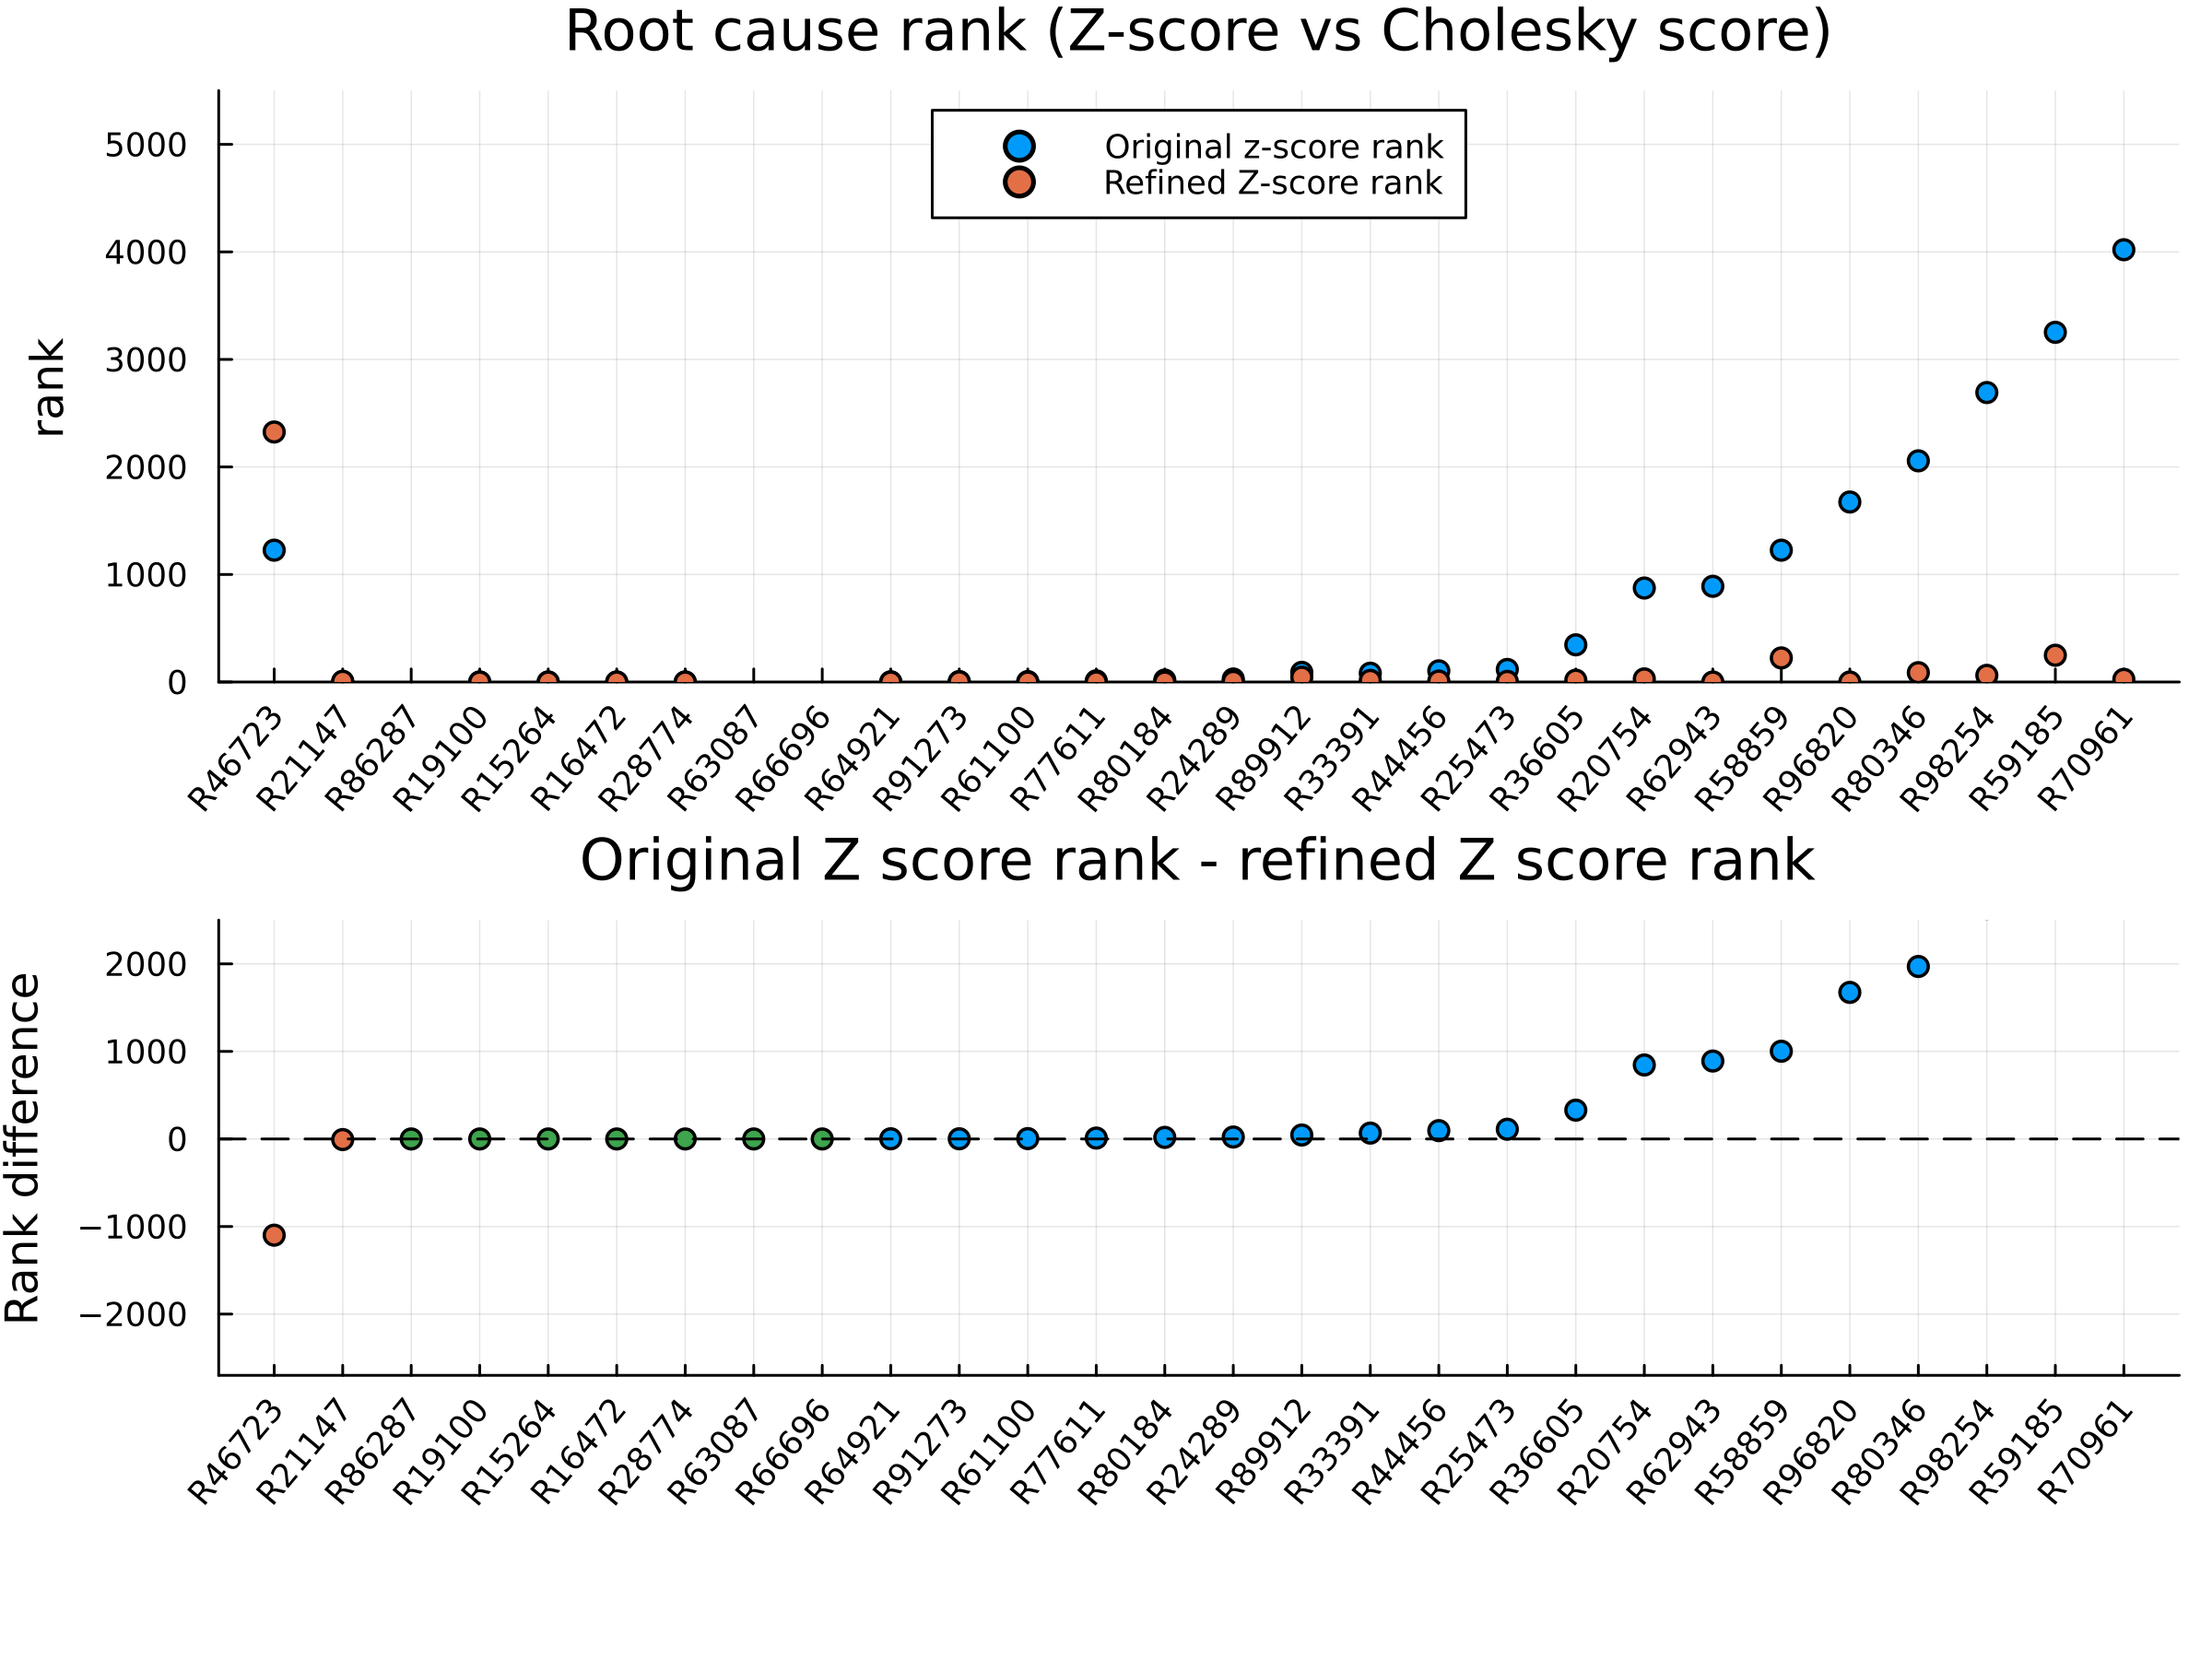

In [30]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.20.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank = count(x -> x > root_cause_cholesky_score, cholesky_score)
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 5.20.2024 (largest support)

+ low_count = 5
+ threshold = 0.1

In [7]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.20.2024/largest_support"
max_acceptable_zscore = 1.5

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Refined Z-score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        patient_root_cause_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        rk = cholesky_score_rank(
            jld2_file, id, ground_truth, Xobs, Xint, 
            max_acceptable_zscore = max_acceptable_zscore, verbose=false
        )
        push!(df, [id, patient_root_cause_rank, rk])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress:  16%|██████▍                                  |  ETA: 0:02:25

ArgumentError(

Progress:  19%|███████▊                                 |  ETA: 0:02:01

"No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.20.2024/largest_support/R15264.jld2")


Progress:  59%|████████████████████████▍                |  ETA: 0:01:08

Root cause did not match


Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


df = 31×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Refined Z-score rank
     │ String        Float64                Float64
─────┼───────────────────────────────────────────────────────────
   1 │ R62943                        890.0                  29.0
   2 │ R98254                       2692.0                 535.0
   3 │ R86287                      16300.0                 Inf
   4 │ R89912                         90.0                  14.0
   5 │ R19100                          0.0                   6.0
   6 │ R36605                        346.0                  14.0
   7 │ R61100                          4.0                   3.0
   8 │ R77611                         11.0                  18.0
   9 │ R16472                          0.0                   2.0
  10 │ R51757                         28.0                   5.0
  11 │ R80346                       2057.0                 383.0
  12 │ R20754                        874.0                  18.0
  13 │ R25473      

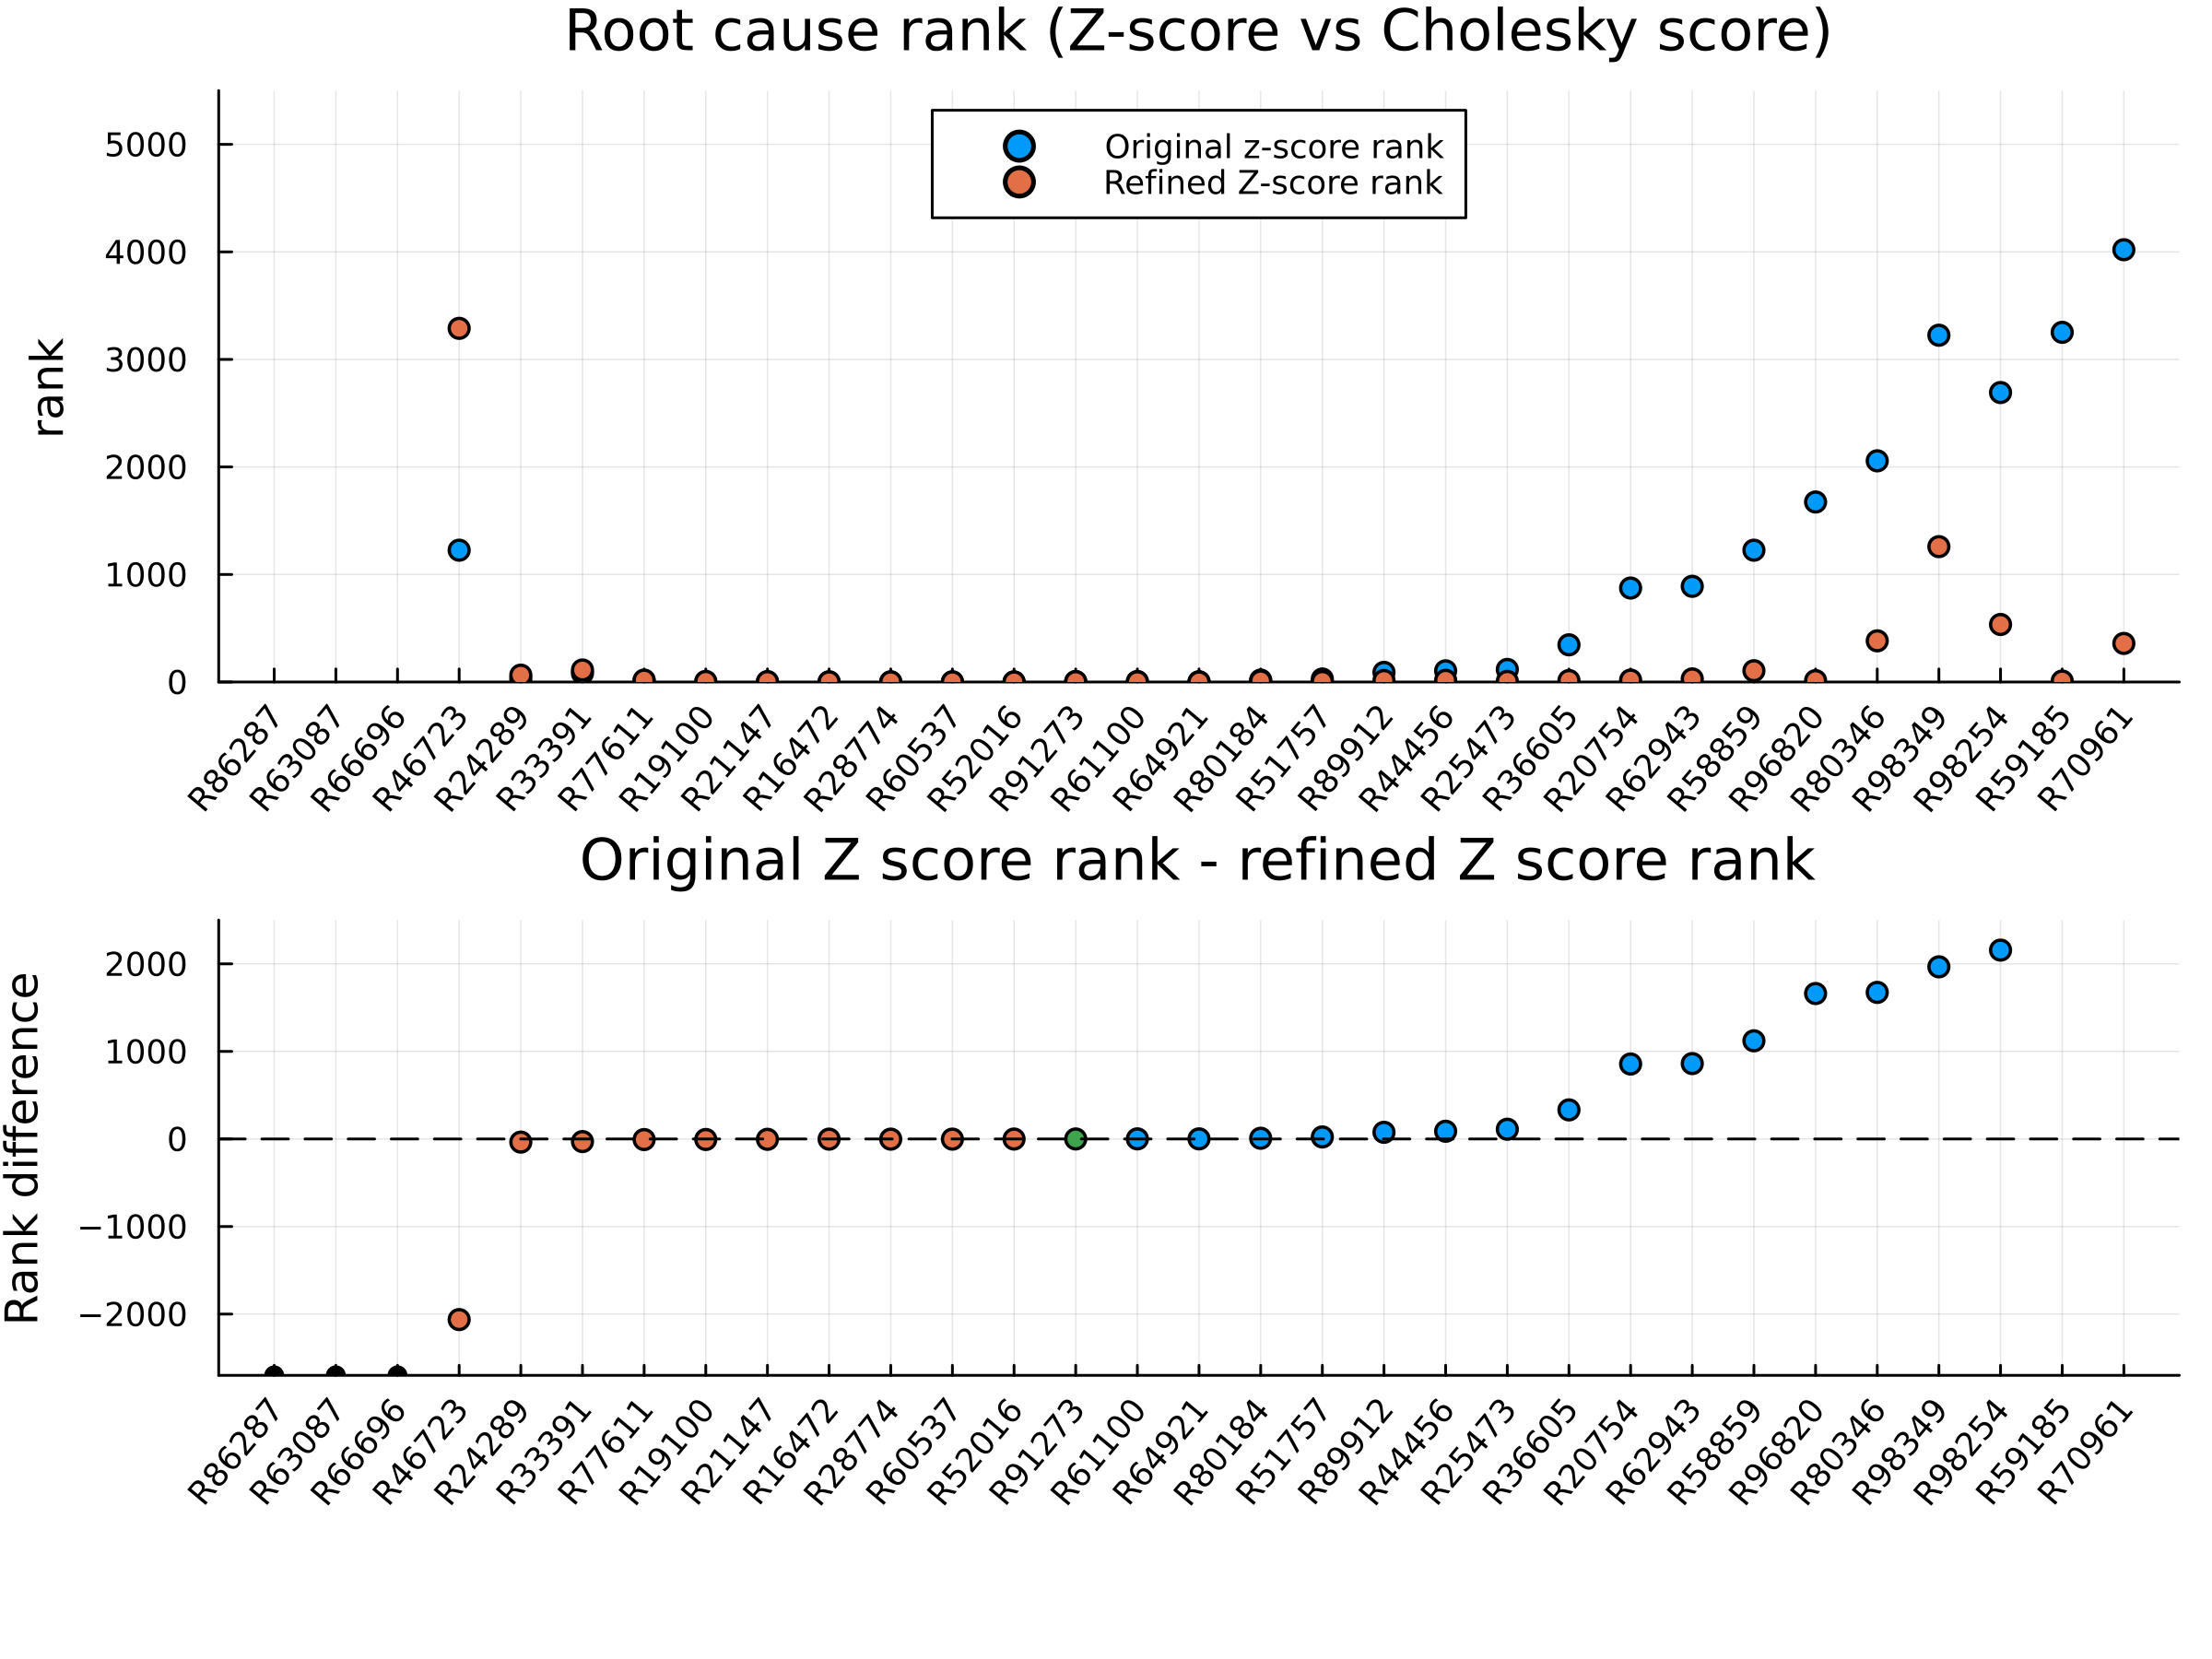

In [8]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Refined Z-score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 5.19.2024 (CV)

+ low_count = 5
+ threshold = 0.05

Progress:   6%|██▌                                      |  ETA: 0:00:31

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R86287.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R36605.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R16472.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R51757.jld2")


Progress:  41%|████████████████▋                        |  ETA: 0:00:14

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R25473.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R96820.jld2")


Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:07

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R59185.jld2")


Progress:  78%|████████████████████████████████         |  ETA: 0:00:06

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R33391.jld2")
ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv/R98349.jld2")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


length(cholesky_score) = 22873
df = 23×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank
     │ String        Float64                Float64
─────┼──────────────────────────────────────────────────────────
   1 │ R62943                        985.0                  0.0
   2 │ R98254                       2948.0                135.0
   3 │ R89912                        107.0                 58.0
   4 │ R19100                          0.0                  0.0
   5 │ R15264                          0.0                  0.0
   6 │ R61100                          5.0                  0.0
   7 │ R77611                         13.0                  0.0
   8 │ R80346                       2363.0                398.0
   9 │ R20754                        938.0                 18.0
  10 │ R28774                          0.0                  0.0
  11 │ R21147                          0.0                  4.0
  12 │ R64921                          2.0                  0.0


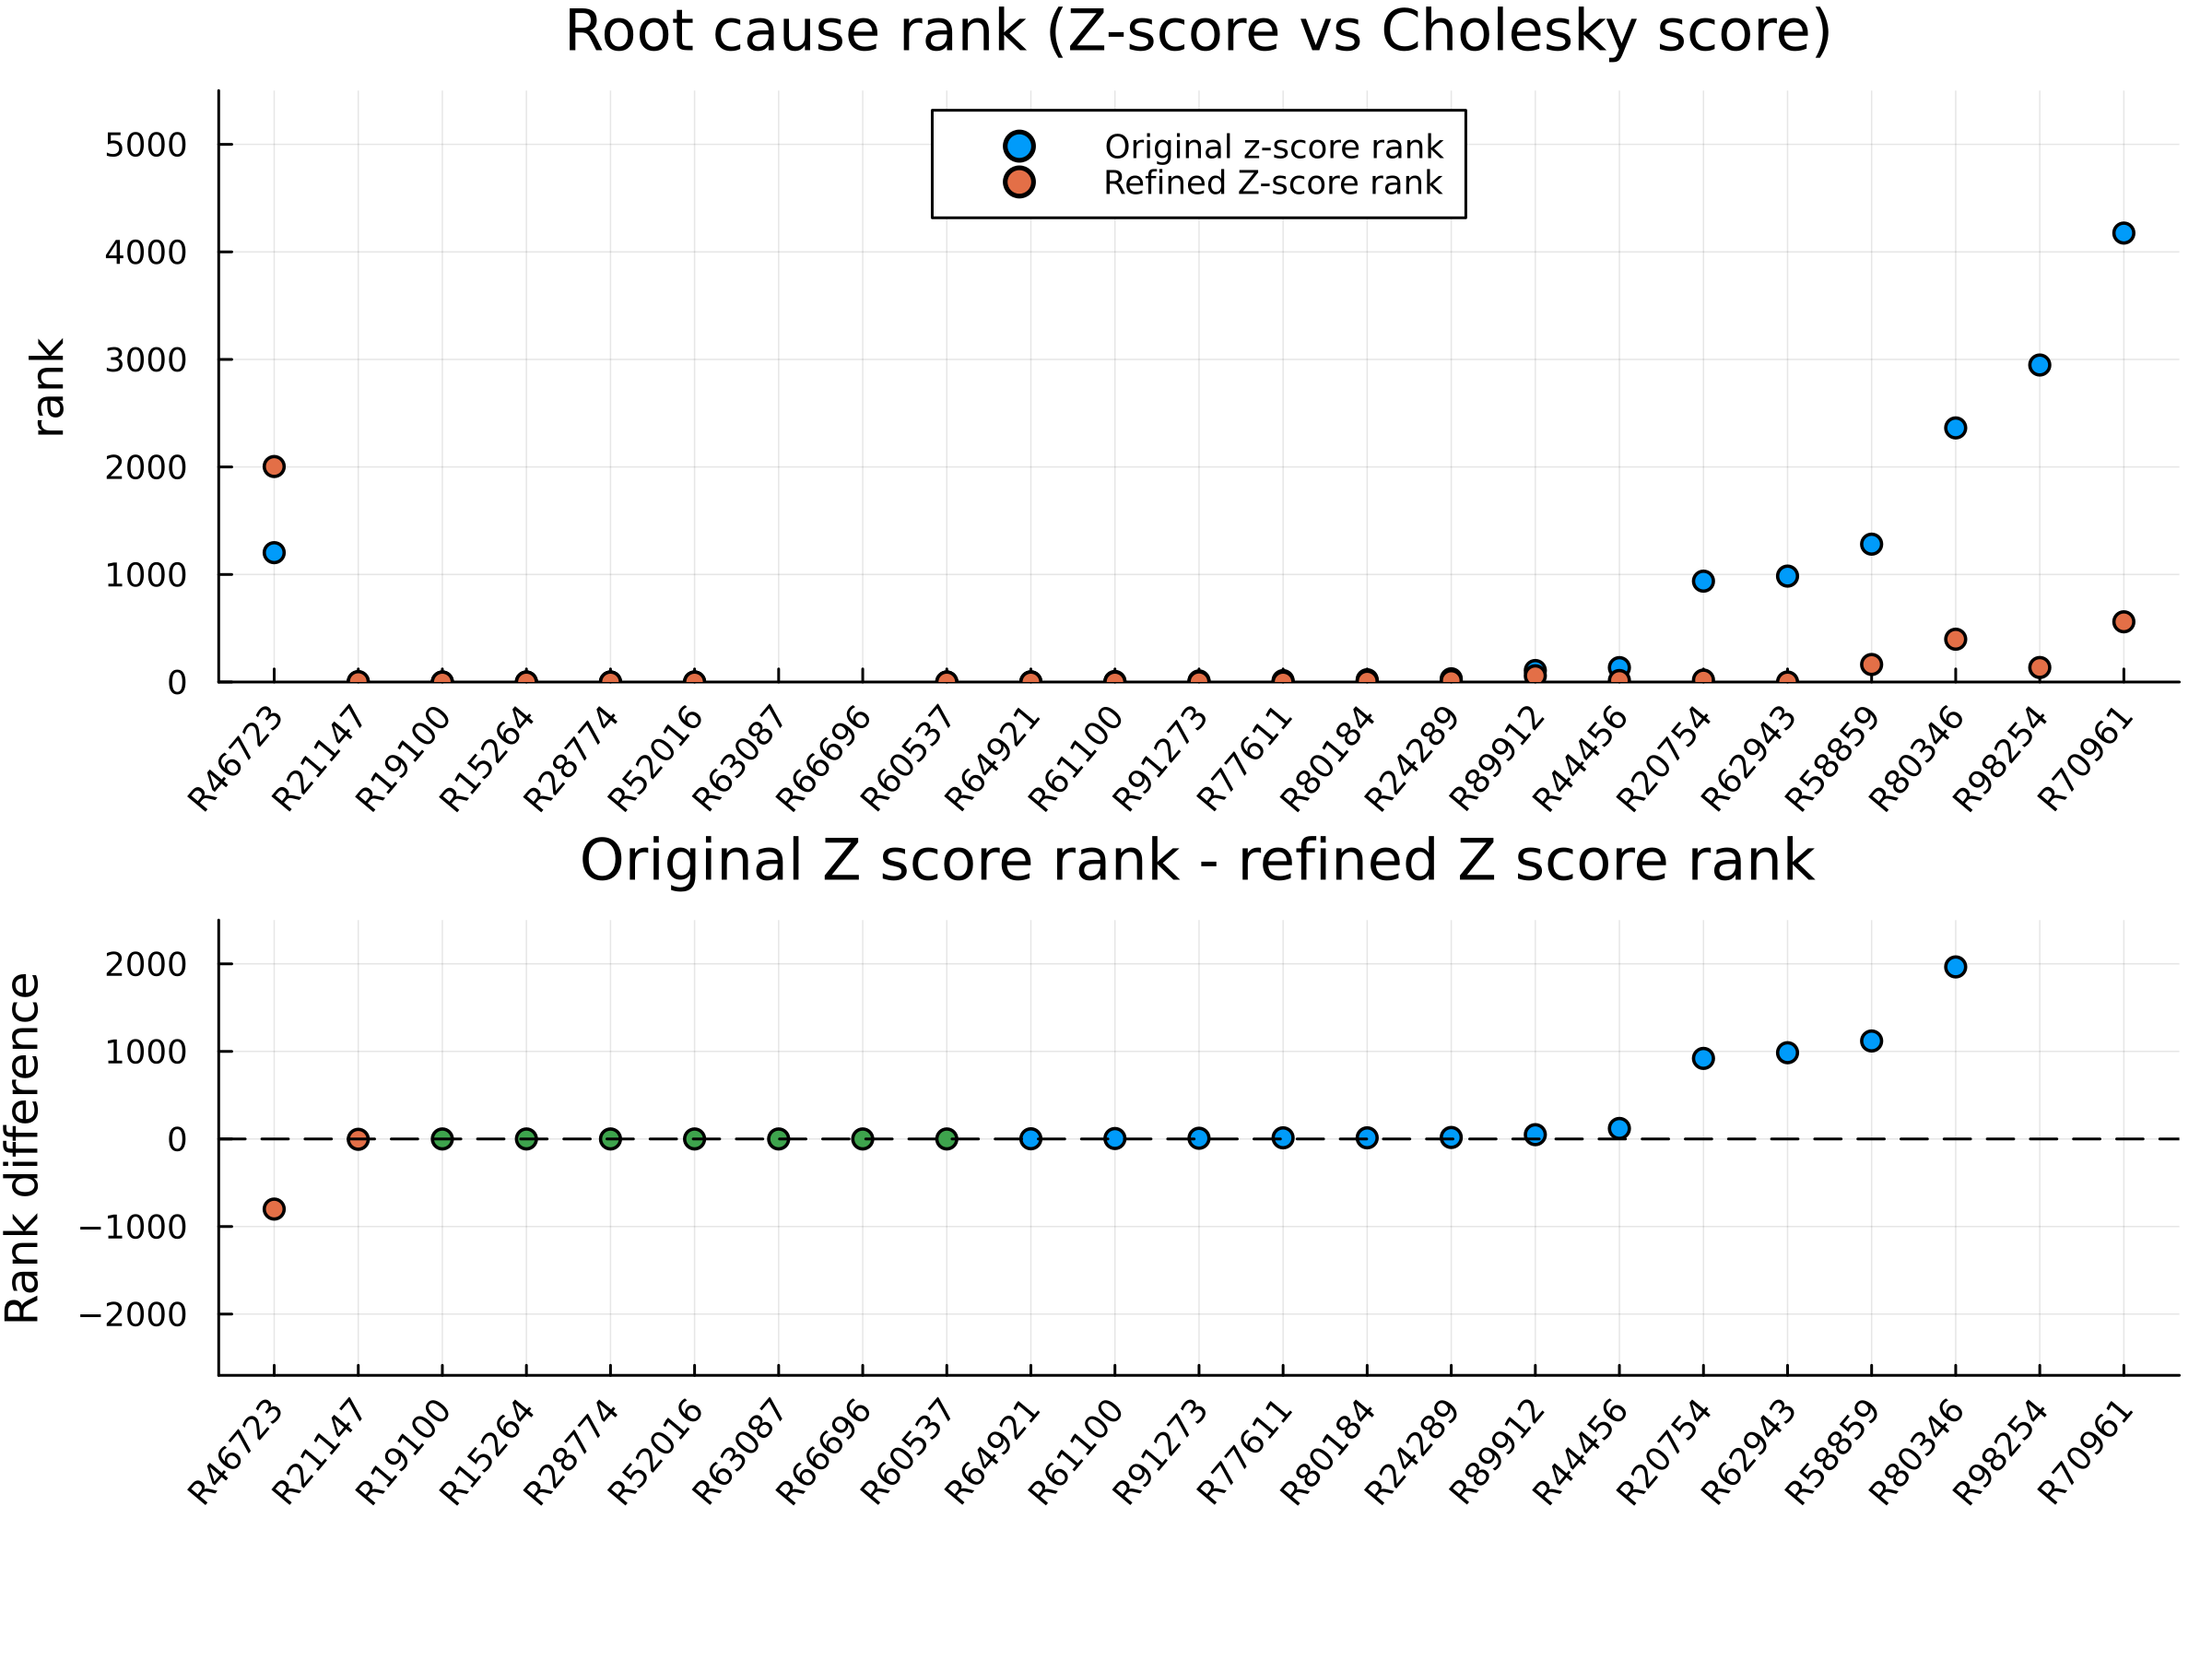

In [28]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.19.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank = count(x -> x > root_cause_cholesky_score, cholesky_score)
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show length(cholesky_score)
@show df;

# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 5.18.2024 (CV)

+ low_count = 10
+ threshold = 0.1

In [23]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.18.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank = count(x -> x > root_cause_cholesky_score, cholesky_score)
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

Progress:  62%|█████████████████████████▋               |  ETA: 0:00:11

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.18.2024/cv/R58859.jld2")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


df = 31×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank
     │ String        Float64                Float64
─────┼──────────────────────────────────────────────────────────
   1 │ R62943                        739.0                  1.0
   2 │ R98254                       2111.0                 14.0
   3 │ R86287                      14630.0              14630.0
   4 │ R89912                         58.0                 11.0
   5 │ R19100                          0.0                  0.0
   6 │ R15264                          0.0                  0.0
   7 │ R36605                        286.0                  6.0
   8 │ R61100                          1.0                  0.0
   9 │ R77611                          5.0                  0.0
  10 │ R16472                          0.0                  0.0
  11 │ R51757                         24.0                 21.0
  12 │ R80346                       1661.0                 29.0
  13 │ R20754                  

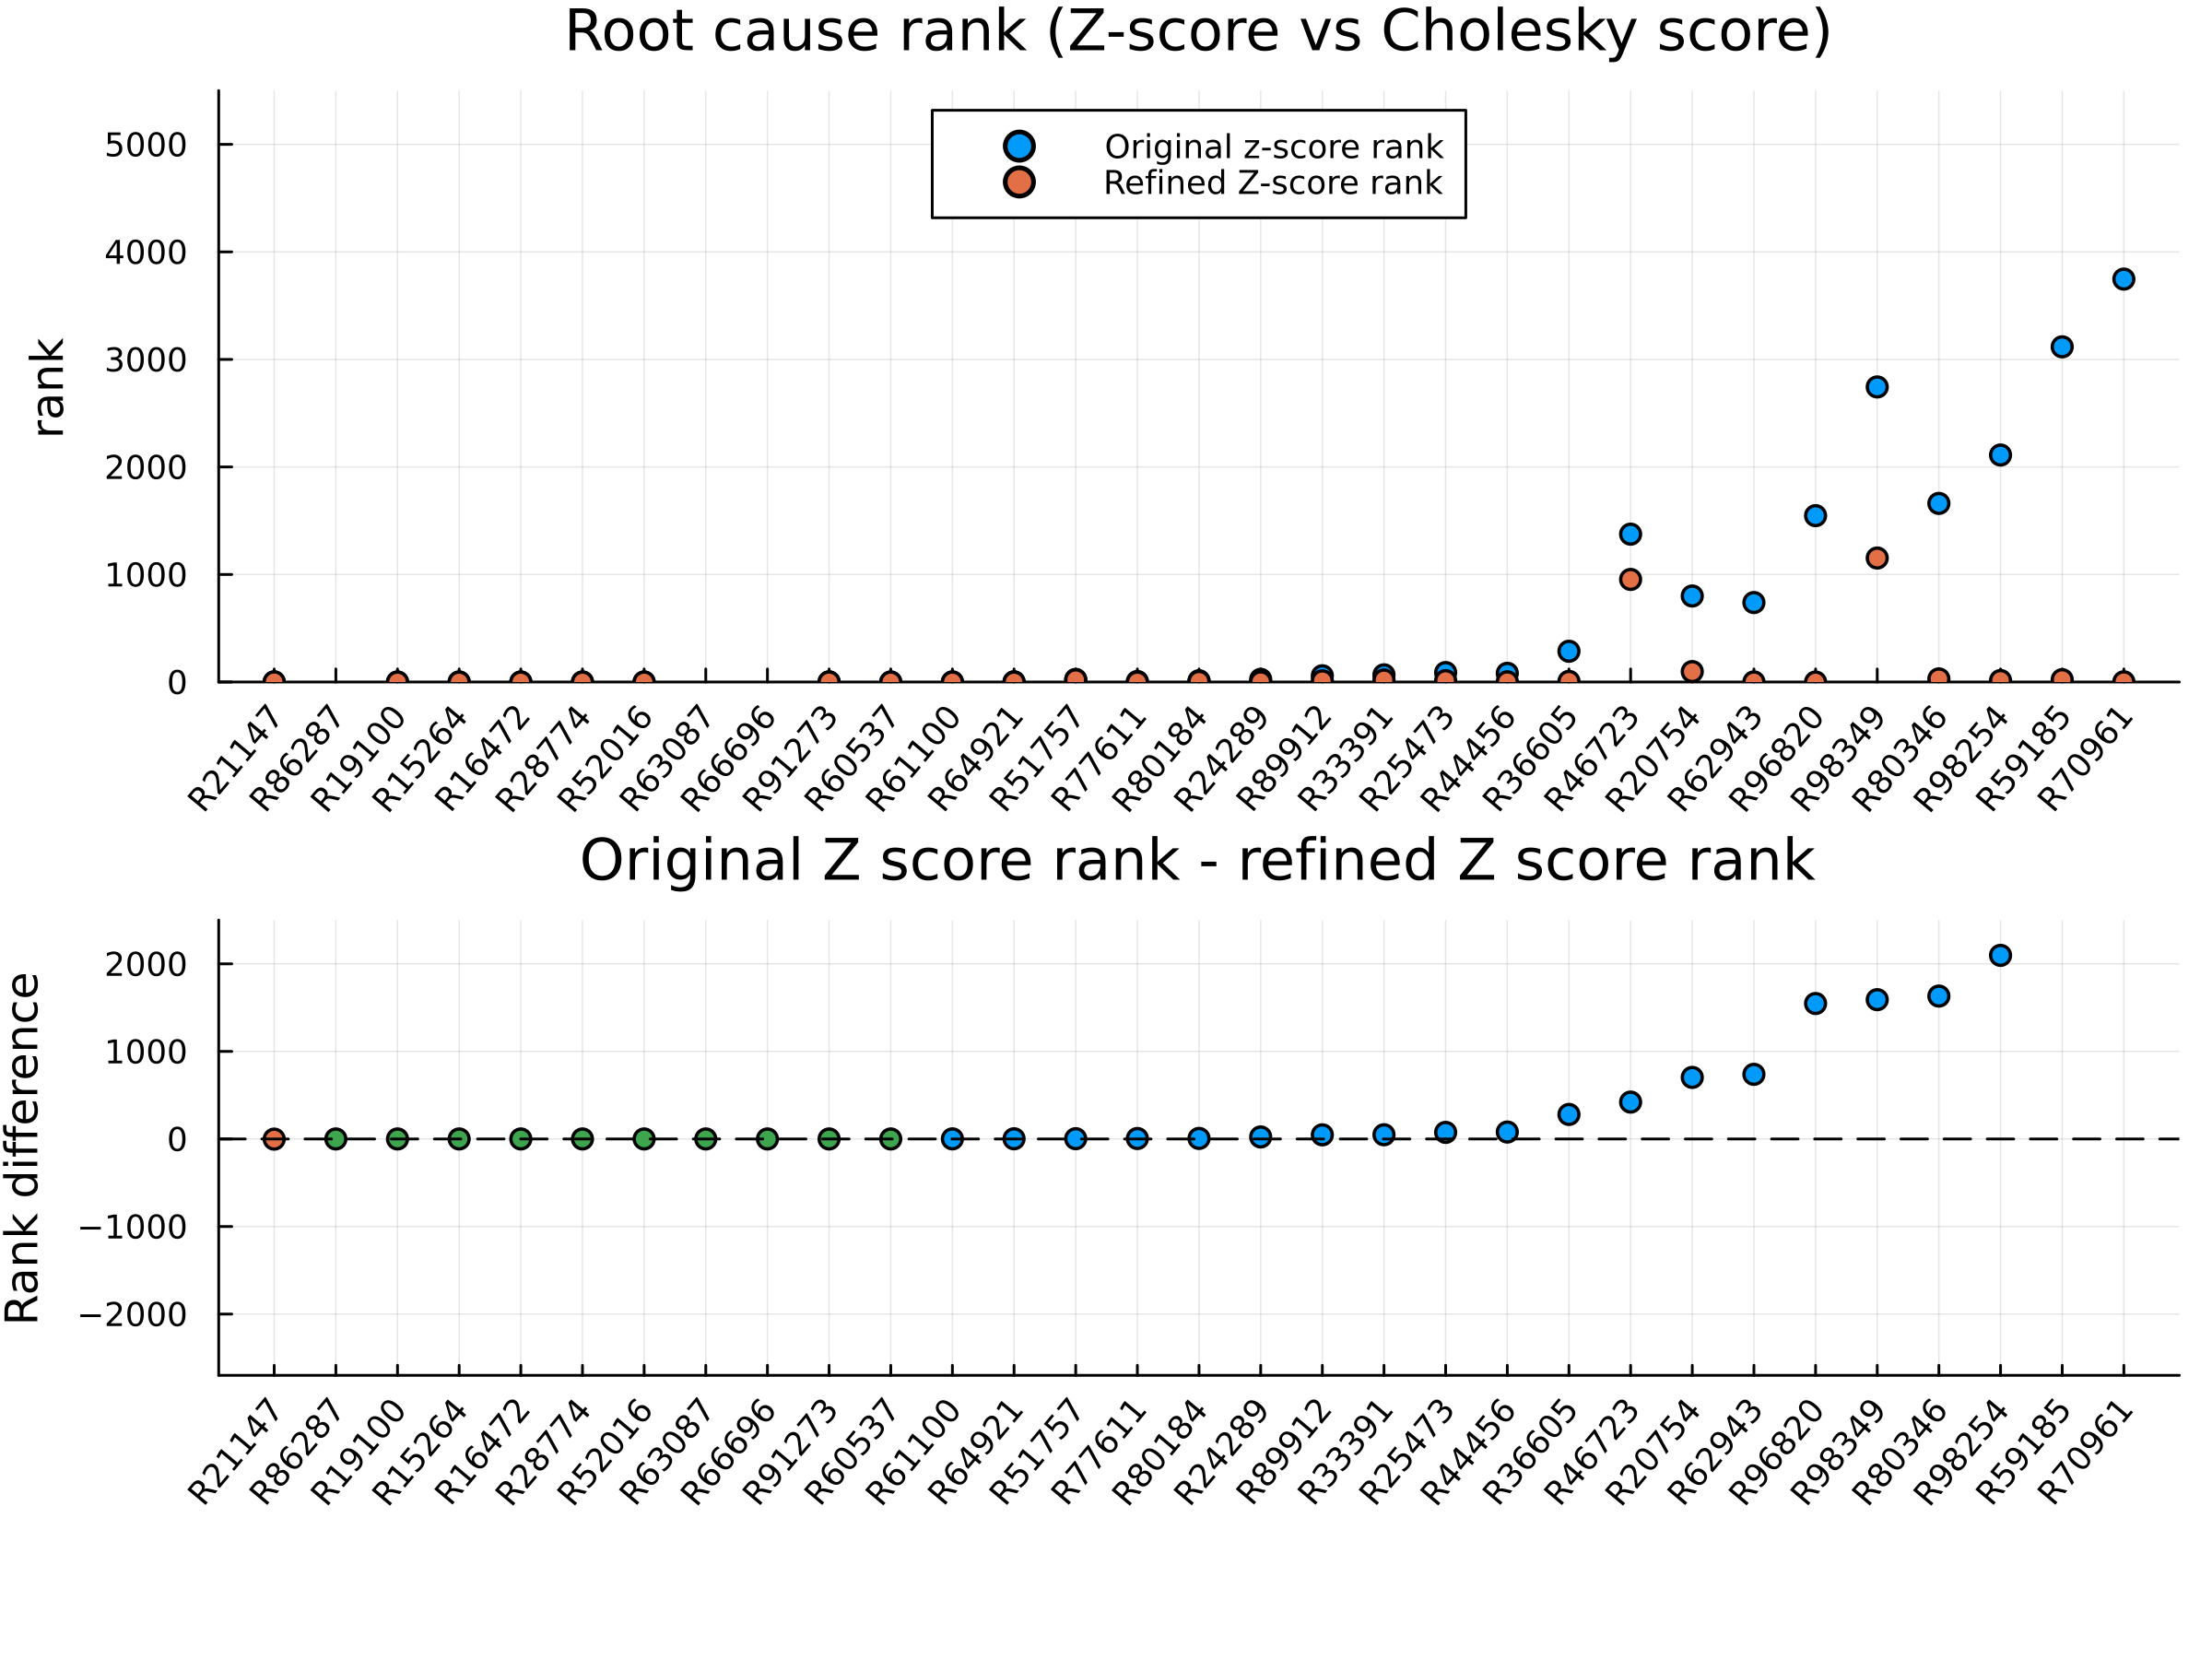

In [24]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)

### 5.11.2024 (CV)

+ low_count = 10
+ threshold = 0.05

In [19]:
outdir = "/scratch/users/bbchu/RootCauseDiscovery/5.11.2024/cv"

# run z score method
z = RootCauseDiscovery.zscore(Xobs, Xint) # each row is a patient, each col a gene, df_z[i, j] is a z score

# compare our method against z score method
df = DataFrame(
    "Patient Name"=>String[],
    "Original Z-score rank"=>Float64[],
    "Cholesky score rank"=>Float64[]
)
patient_name = ground_truth[!, "Patient ID"]
@showprogress for (i, id) in enumerate(patient_name)
    try
        patient_root_cause_idx = ground_truth[i, "root cause row index in genecounts"]
        patient_root_cause_zscore = z[i, patient_root_cause_idx]
        root_cause_zscore_rank = 
            count(x -> x > patient_root_cause_zscore, @view(z[i, :]))

        # root cause discovery
        jld2_file = joinpath(outdir, "$id.jld2")
        cholesky_score = JLD2.load(jld2_file)["root_cause_score"]
        root_cause_cholesky_score = cholesky_score[patient_root_cause_idx]
        root_cause_chol_rank = count(x -> x > root_cause_cholesky_score, cholesky_score)
        push!(df, [id, root_cause_zscore_rank, root_cause_chol_rank])
        GC.gc();GC.gc();GC.gc();
    catch e
        println(e)
        continue
    end
end

@show df;

ArgumentError("No file exists at given path: /scratch/users/bbchu/RootCauseDiscovery/5.11.2024/cv/R62943.jld2")


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


df = 31×3 DataFrame
 Row │ Patient Name  Original Z-score rank  Cholesky score rank
     │ String        Float64                Float64
─────┼──────────────────────────────────────────────────────────
   1 │ R98254                       2299.0                  9.0
   2 │ R86287                      15417.0              15417.0
   3 │ R89912                         72.0                 30.0
   4 │ R19100                          0.0                  0.0
   5 │ R15264                          0.0                  0.0
   6 │ R36605                        306.0                 13.0
   7 │ R61100                          2.0                  0.0
   8 │ R77611                          8.0                  1.0
   9 │ R16472                          0.0                  0.0
  10 │ R51757                         26.0                 21.0
  11 │ R80346                       1873.0                121.0
  12 │ R20754                        842.0                  9.0
  13 │ R25473                  

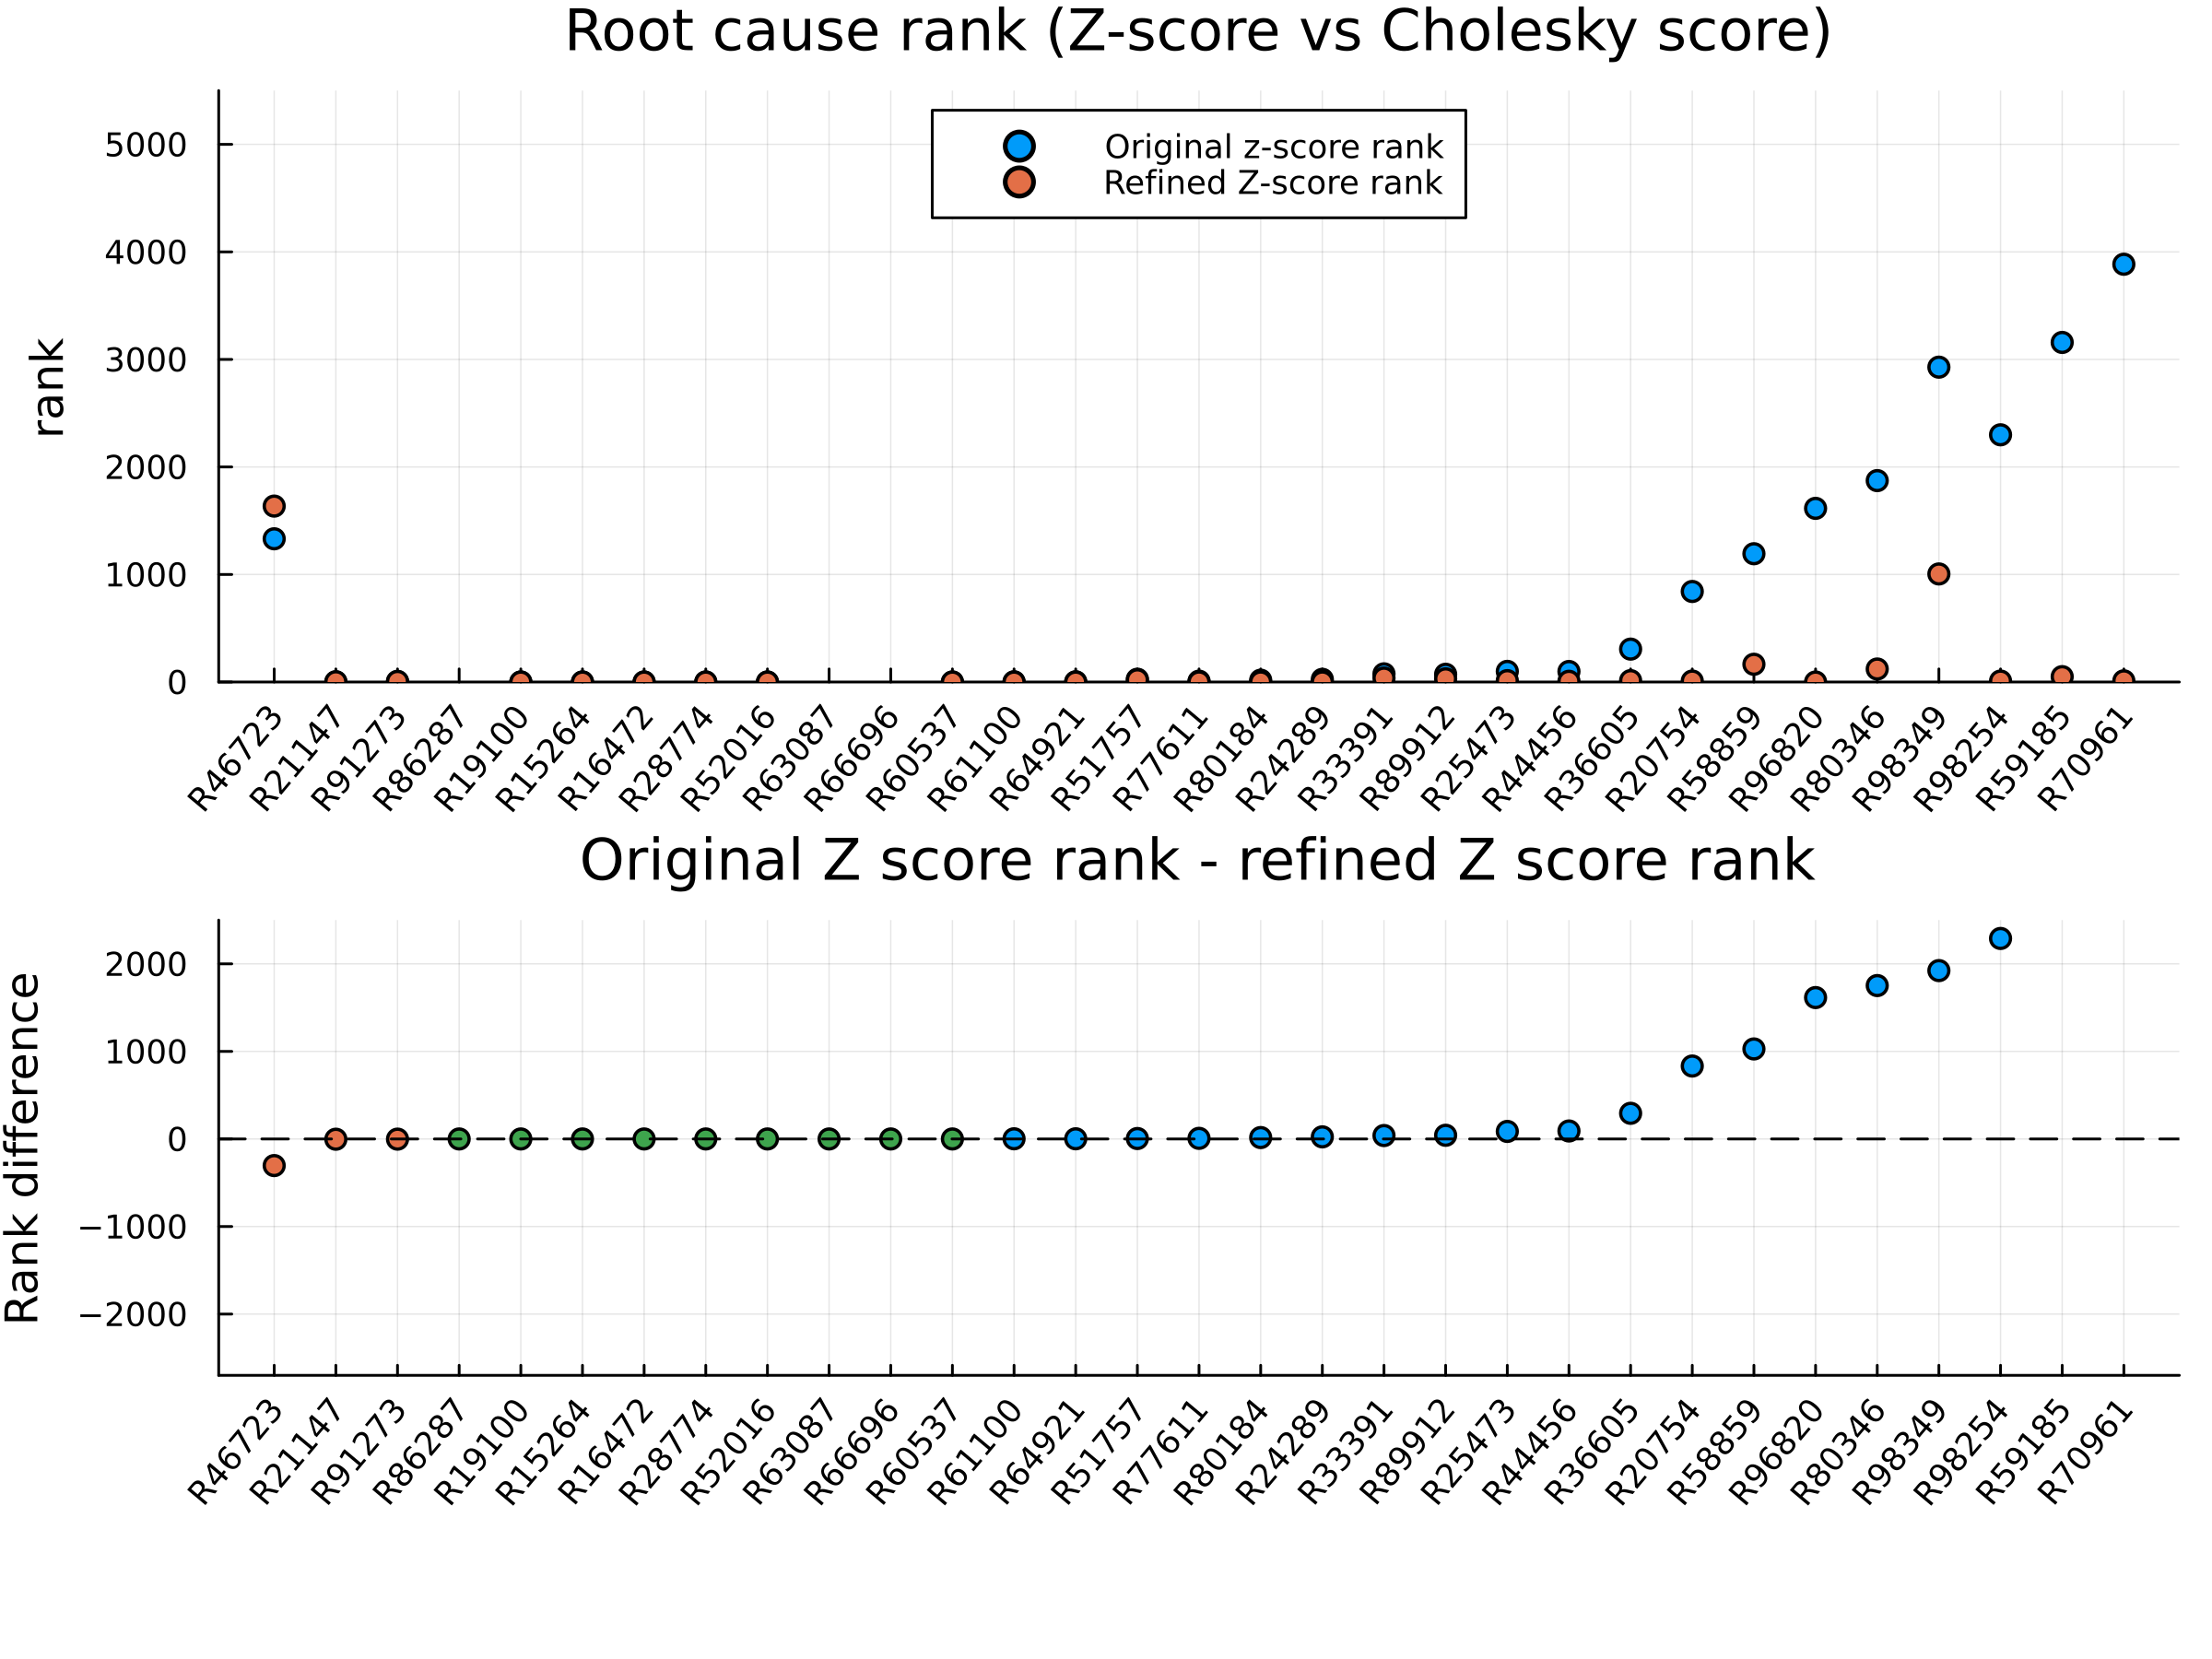

In [21]:
# only plot completed patients
patient_name_success = df[!, "Patient Name"]
Z_score_rank = df[!, "Original Z-score rank"]
RCD_rank = df[!, "Cholesky score rank"]

# make plot
plt = make_plot(Z_score_rank, RCD_rank, patient_name_success;
    plot1_ymax = 5500, plot2_ymin = -2700, plot2_ymax = 2500
)
plot(plt)